In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[What is in the library at OpenAI headquarters?](https://www.nytimes.com/2024/05/15/technology/openai-library-office.html)

___

[Google's 12 biggest announcements.](https://twitter.com/rowancheung/status/1790556720512516281)

___

Search? What is search?

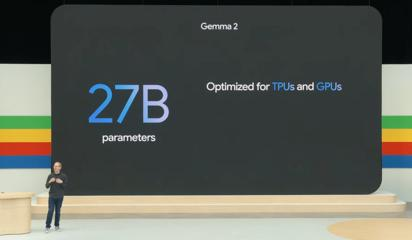

[Google will release a 27b-parameter open source model, says it delivers performance comparable to Llama-3 70b.](https://techcrunch.com/2024/05/14/google-announces-gemma-2-a-27b-parameter-version-of-its-open-model-launching-in-june/) - TechCrunch

___

[Gemini also watched the OpenAI announcement, said it was impressed. The future is weird.](https://twitter.com/mmmbchang/status/1790473581018939663)

___

[Gemini 1.5 Flash watches itself being announced.](https://twitter.com/GoogleDeepMind/status/1790463259822420239)

___

[Ilya is out -](https://twitter.com/ilyasut/status/1790517455628198322)

___

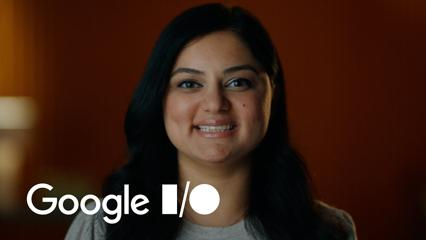

[How devs are using 1m tokens. It is a game-changer. TBH I didn't have as much success getting Gemini 1.5 to understand video as they showed in their Astra demo. www.youtube.com/watch?v=cogr... . Just this morning I said, it won't tell you where you left your glasses, which they demoed.](https://www.youtube.com/watch?v=cogrixfRvWw) - YouTube

___

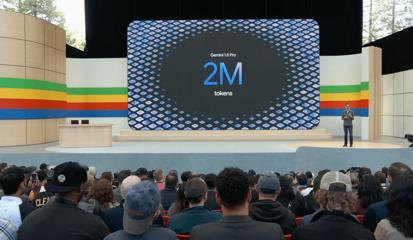

[Google announces a lower-latency Gemini Flash model, and  a preview of a 2m-token context model.](https://techcrunch.com/2024/05/14/googles-generative-ai-model-can-now-analyze-hours-of-video/) - TechCrunch

___

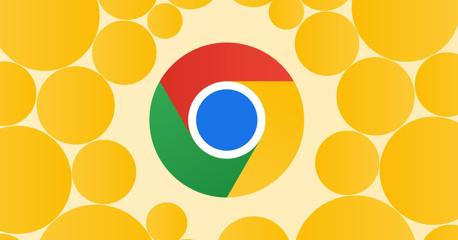

[Google is putting Gemini Nano inside Chrome to help with filling out forms, suggestions and whatnot.](https://www.theverge.com/2024/5/14/24155382/google-gemini-ai-chrome-nano-io) - The Verge

___

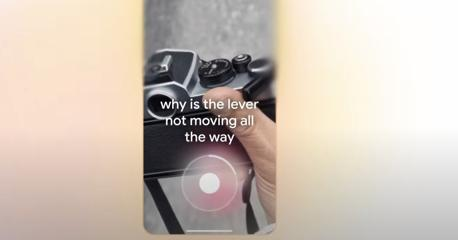

[In Google's demo, when asked how to fix a film camera with a stuck advance lever, Gemini suggests opening the back door and gently removing the film. Oops.](https://www.theverge.com/2024/5/14/24156729/googles-gemini-video-search-makes-factual-error-in-demo) - The Verge

___

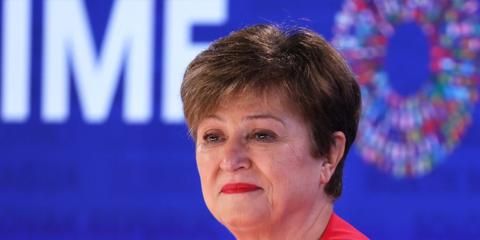

[AI will hit the labor market like a ‘tsunami,’ says IMF chief. Reassuring.](https://fortune.com/2024/05/14/ai-tsunami-imf-chief-labor-market-job-loss/) - Fortune

___

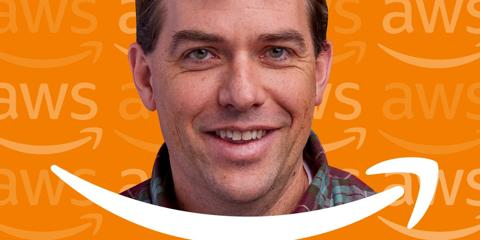

[AWS CEO out after 3 years with mixed reviews.](https://www.businessinsider.com/aws-insiders-mixed-views-ceo-adam-selipskys-tenure-daparture-2024-5) - Business Insider

___

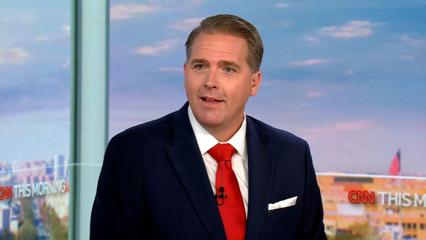

[Can you replace a Republican political consultant with AI? CNN asking the tough questions.](https://www.cnn.com/2024/05/14/business/video/chatgpt-openai-video-cnn-scott-jennings-digvid) - CNN

___

'I made this'

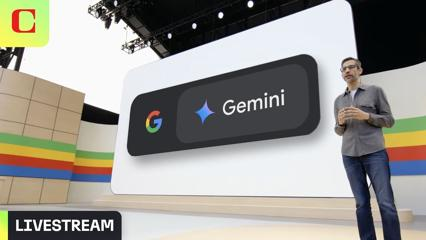

[Full keynote - go to 19:00 for Sir Demis](https://www.youtube.com/watch?v=5k_l5VoRC60) - YouTube

___

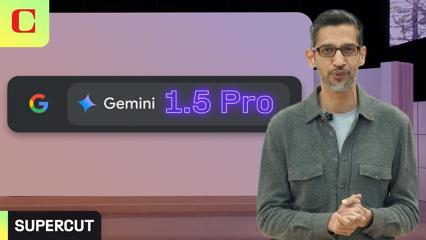

[Everything Google talked about today, in 12 minutes.](https://www.youtube.com/watch?v=PE89NysJEUY) - YouTube

___

Testing LLMs on coding problems, we see a huge gap between success on well-known problems and novel problems.

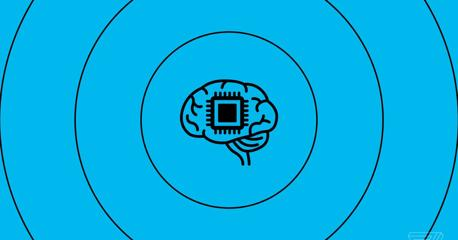

[Everyone's making their own AI chip now, including a lot of folks not mentioned here.](https://www.theverge.com/2024/2/1/24058186/ai-chips-meta-microsoft-google-nvidia) - The Verge

___

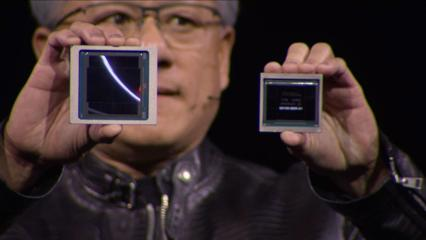

[Estimates predict \\$70k for Nvidida B200 chips, a full server rack will run you \\$3m, not including the nuclear plant to power it.](https://www.tomshardware.com/pc-components/gpus/nvidias-next-gen-blackwell-ai-gpus-to-cost-up-to-dollar70000-fully-equipped-servers-range-up-to-dollar3000000-report) - Tom's Hardware

___

[xAI in \\$10b cloud deal with Oracle Cloud, which sets off my BS detector. Like, window dressing and not really a \\$10b commitment, or not really an arms length market price transaction but some kind of quid pro quo.](https://www.bloomberg.com/news/articles/2024-05-14/oracle-jumps-on-report-of-10-billion-cloud-deal-with-musk-s-xai)

___

In the short run the naysayers might score a couple of points, but it's really in the long run that we are utterly doomed.

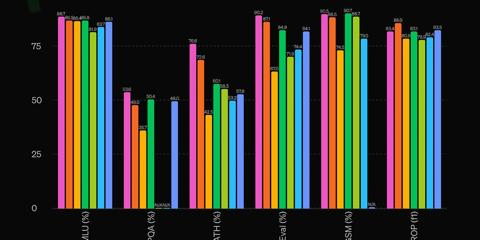

[I posted some thoughts - www.skynetandchill.com/p/ai-reading...

I got the Mac app but it's still just a native version of the web UI, doesn't have the conversational chat or ability to watch your screen, like they demoed. A lot of sizzle but I'm still waiting for the steak LOL.](https://garymarcus.substack.com/p/hot-take-on-openais-new-gpt-4o?r=8tdk6&utm_campaign=post&utm_medium=web&triedRedirect=true)

___

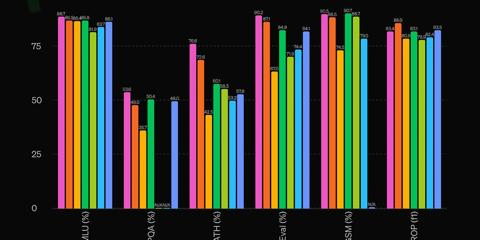

[Gary Marcus has thoughts and spin.](https://garymarcus.substack.com/p/hot-take-on-openais-new-gpt-4o?r=8tdk6&utm_campaign=post&utm_medium=web&triedRedirect=true)

___

[Roose on Samantha](https://www.nytimes.com/2024/05/14/technology/ai-chatgpt-her-movie.html)

___

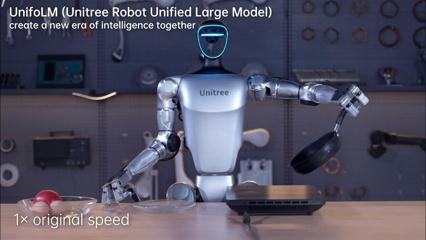

[An 'affordable' \\$16k humanoid robot -](https://www.youtube.com/watch?v=Yuyz_Cw0kEg&t=17s) - YouTube

___

[Some demos of music from ElevenLabs. The first one is definitely a simple chord progression directly from a song (or two) that is already out there.](https://twitter.com/elevenlabsio/status/1788628171044053386)

___

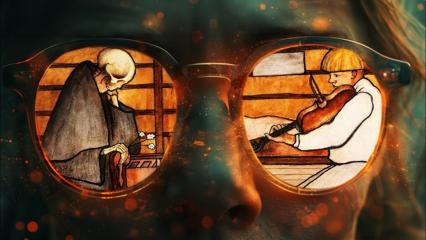

[A violin recital composed and played by AI.](https://www.youtube.com/watch?v=iQ6ITnYAIok&t=240s) - YouTube

___

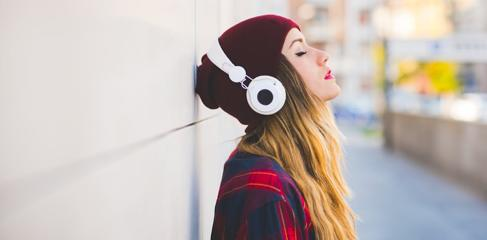

[AI can make up songs now, but who owns the copyright?](https://theconversation.com/ai-can-make-up-songs-now-but-who-owns-the-copyright-the-answer-is-complicated-229714) - The Conversation

___

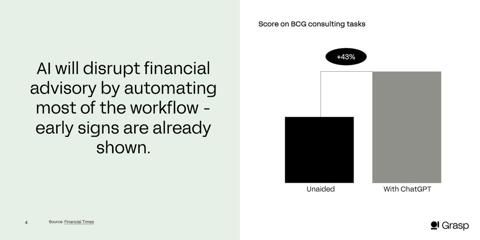

[Swedish startup aims to use AI to disrupt financial advisory.](https://www.businessinsider.com/grasp-swedish-startup-pitch-deck-disrupt-financial-services-consultants-ai-2024-5) - Business Insider

___

[Another weird/creepy AI ad, although this one mocks AI so maybe the creatives need to chill. I get why they are butthurt though.](https://www.fastcompany.com/91124155/kfc-used-ai-for-a-new-ad-and-it-didnt-go-as-planned)

___

[A short combining Sora with real actors.](https://twitter.com/shykids/status/1789030711866937346)

___

/opt/anaconda3/envs/ainewsbot/lib/python3.9/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


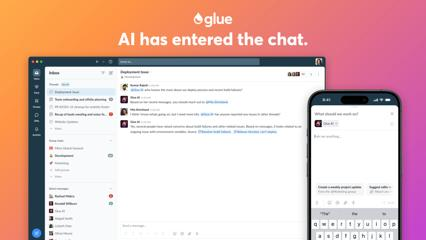

[David Sacks shows Glue, a Slack/Teams competitor that will help your chats be better with AI. (possibly by inserting Putin talking points and rewriting all posts from an extreme right standpoint.)](https://techcrunch.com/2024/05/14/david-sacks-glue-ai-slack-microsoft-teams-alternative/) - TechCrunch

___

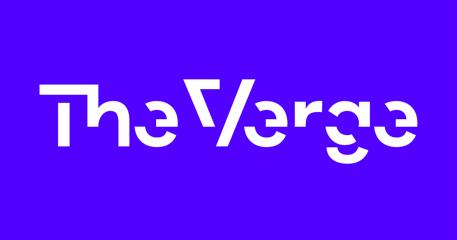

[Stealing Google's thunder much?](https://www.theverge.com/2024/5/14/24156208/google-teases-fast-multimodal-ai) - The Verge

___

These numbers plus lack of huge context window don't dispel the sense they are still the gorilla but Claude, Gemini 1.5, Llama-3 are giving them a run for their money. Faster/cheaper/multimodal is important but sort of clearing technical debt, Sora/Samantha demos are sort of flashy window dressing.

These benchmarks are a small improvement over GPT-4-turbo and this plus price cut should stave off people who might be tempted to switch to Opus.

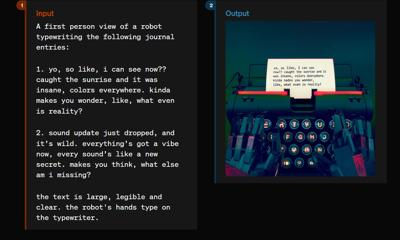

[Ethan Mollick on GPT-4o. He got access to the model early but not the ability to see and hear stuff, which to me suggests it's probably still janky. Also no app download yet? Maybe OpenAI showing stuff off before it's fully baked to buy time, like Sora?](https://www.oneusefulthing.org/p/what-openai-did?r=i5f7&utm_campaign=post&utm_medium=web&triedRedirect=true)

___

will be interesting to see how well it really understands what it sees on video in real-time, because that is a potentially huge new capability, but I'm guessing it might be pretty janky.

butterfly meme, is this agi?

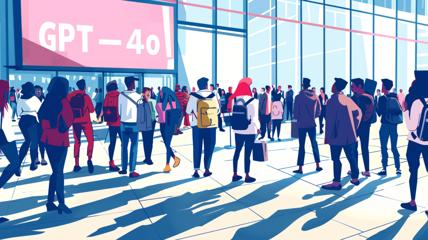

[The underlying model is essentially the same though, just wrapped in a better UI? But now they anthropomorphized it, gave it personality. Which might drive adoption but is also super problematic. One could argue that AIs must present as AIs. And people hear it and say, this is AGI?](https://venturebeat.com/ai/gpt-4o-first-reactions-essentially-agi/) - VentureBeat

___

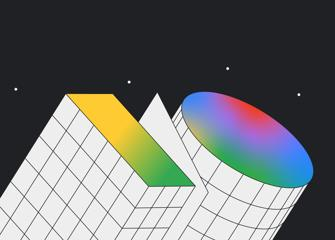

[Google I/O coming later, can probably follow live blogs and the Google Twitter www.theverge.com/live twitter.com/google](https://www.theverge.com/live) - The Verge

___

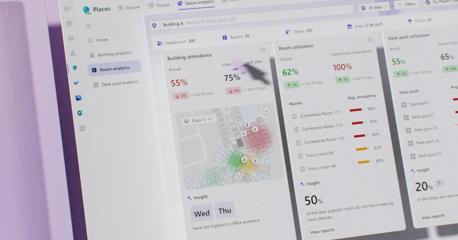

[Microsoft Places helps manage office space, use AI to pick meeting rooms, help hybrid workers decide which days to go into the office.](https://www.theverge.com/2024/5/13/24155204/microsoft-places-ai-hybrid-office-feature) - The Verge

___

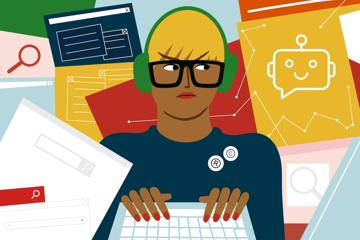

[Publishers brace for carnage as AI is expected to reduce traffic from search by 25% over next couple of years.](https://www.washingtonpost.com/technology/2024/05/13/google-ai-search-io-sge/) - Washington Post

___

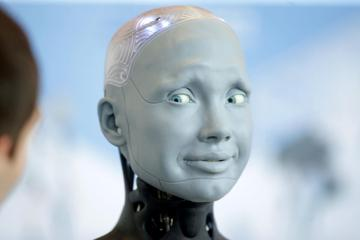

[What will it take to stop the AI denial train? www.forbes.com/sites/stevea... Definitely a lot of hype. Definitely some scary stuff. Maybe people are overinvesting and overvaluing comapnies. But hard to deny its significance.](https://www.forbes.com/sites/steveandriole/2024/05/13/the-ai-denial-train-should-stop/?sh=b4224558f88c) - Forbes

___

When are they going to acknowledge they trained it to sound like Scarlett Johansson though?

[Sam Altman writes about it, says the big deal is it puts great stuff out for free for everyone, and it feels viscerally different to be able to have a natural conversation with a computer.](https://blog.samaltman.com/gpt-4o) - Sam Altman

___

[A side by side speed comparison.](https://www.reddit.com/r/OpenAI/comments/1cr67y9/gpt4o_is_crazy_fast_they_shouldve_named_it/)

___

[Some GPT-4o assistant demos. Sounds quite expressive, with personality. I wonder how much it actually understands when watching your screen or your surroundings, could you show it a workflow and say, automate this. Gemini with video can't really do that properly and this has smaller context window.](https://openai.com/index/hello-gpt-4o/)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 15, 13, 0, 44, 421000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-14 03:18:55.363143


In [14]:
import openai
import os

def get_chatgpt_response(prompt, model="gpt-3.5-turbo"):
    """
    This function sends a prompt to the ChatGPT model and returns its response.

    Args:
        prompt (str): The text prompt you want to send to ChatGPT.
        model (str, optional): The ChatGPT model to use (default: "gpt-3.5-turbo").

    Returns:
        str: The response text from ChatGPT.
    """

    try:
        # Check for required environment variable
        if "OPENAI_API_KEY" not in os.environ:
            raise ValueError("OPENAI_API_KEY environment variable not found.")

        openai.api_key = os.environ["OPENAI_API_KEY"]
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt},
            ],
        )
        return response.choices[0].message["content"]

    except openai.error.OpenAIError as e:
        # Handle OpenAI API errors
        print(f"OpenAI API Error: {e}")
        return None

    except Exception as e:
        # Handle other unexpected errors
        print(f"An error occurred: {e}")
        return None

# Example usage
prompt = "What's the weather like today in New York?"
response = get_chatgpt_response(prompt)
if response:
    print(f"ChatGPT response: {response}")


AttributeError: module 'openai' has no attribute 'error'